# Data Visualization

In [54]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import matplotlib.pyplot as plt
import ast
import gensim, logging
import xgboost
import lightgbm
import datetime

In [55]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/evaluation.csv')
train_df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [56]:
train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


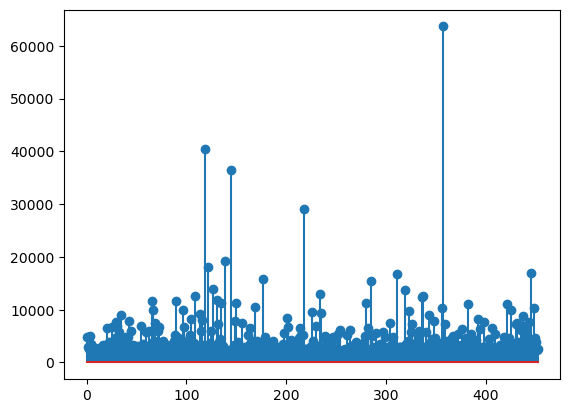

In [57]:
plt.stem(train_df[train_df['retweets_count'] > 2000]['retweets_count'])
plt.show()

In [58]:
train_df = train_df[train_df['retweets_count'] < 20000]
train_df.shape

(353965, 12)

In [59]:
def format_data(df: pd.DataFrame, type: str = 'train', url_len_only: bool = False, hashtag_len_only: bool = False, keep_time: bool = False, normalize: bool = False, mean: np.ndarray = None, std: np.ndarray = None):
    final_df = df.drop(['TweetID', 'mentions', 'text', 'timestamp'], axis=1)

    final_df.urls = final_df.urls.apply(ast.literal_eval)
    final_df.hashtags = final_df.hashtags.apply(ast.literal_eval)
    if url_len_only:
        final_df.urls = final_df.urls.apply(len)
    if hashtag_len_only:
        final_df.hashtags = final_df.hashtags.apply(len)

    if keep_time:
        timestamps = df.timestamp // 1000
        timestamps = timestamps.apply(datetime.datetime.fromtimestamp).apply(datetime.datetime.timetuple)

        time_df = pd.DataFrame(timestamps.tolist(), index=df.index, columns=['tm_year', 'tm_mon', 'tm_mday', 'tm_hour', 'tm_min', 'tm_sec', 'tm_wday', 'tm_yday', 'tm_isdst'])
        time_df = time_df.drop(['tm_mday', 'tm_isdst'], axis=1)

        final_df = pd.concat([final_df, time_df], axis=1)
        final_df = final_df[final_df['tm_year'].values == 2022].drop(['tm_year'], axis=1)
        final_df = final_df[final_df['tm_mon'].values == 3].drop(['tm_mon'], axis=1)

    if url_len_only and hashtag_len_only and normalize:
        values = final_df.values
        if mean is None or std is None:
            values = (values - values.mean(0)) / values.std(0)
        else:
            values = (values - mean) / std
        final_df = pd.DataFrame(data=values, columns=final_df.columns)

    return final_df

In [60]:
train_df = format_data(train_df, keep_time=True, url_len_only=True, hashtag_len_only=True, normalize=False)

train_df_input = train_df.drop(['retweets_count'], axis=1)
train_df_input

,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags,tm_hour,tm_min,tm_sec,tm_wday,tm_yday
0,0,3682,453535,3628,0,0,0,6,54,8,4,70
1,0,86,1016,284,0,0,0,13,51,28,5,78
2,1,1944,28234,1995,0,0,0,19,47,28,1,74
3,0,1,1072,0,1,0,0,12,11,22,0,73
4,0,13957,25311,10841,0,0,0,12,46,14,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,0,34,1509,55,1,0,0,14,42,33,2,75
353965,0,89,11166,127,0,0,0,9,1,46,5,71
353966,0,1888,712,3086,0,0,0,13,40,30,4,77
353967,0,139,486,320,0,0,0,9,26,35,4,70


In [61]:
test_df_input = format_data(test_df, type='test', url_len_only=True, hashtag_len_only=True)
test_df_input

,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags
0,0,85,4442,327,0,0,2
1,0,427,33282,443,0,0,0
2,6,1127,13111,1596,0,0,1
3,2,1699,25760,2036,1,0,0
4,0,249,20718,369,2,0,0
...,...,...,...,...,...,...,...
117985,0,4,194,64,0,0,0
117986,0,744,39489,894,1,0,0
117987,12,924,2270,159,0,0,0
117988,0,5,4,80,1,0,0


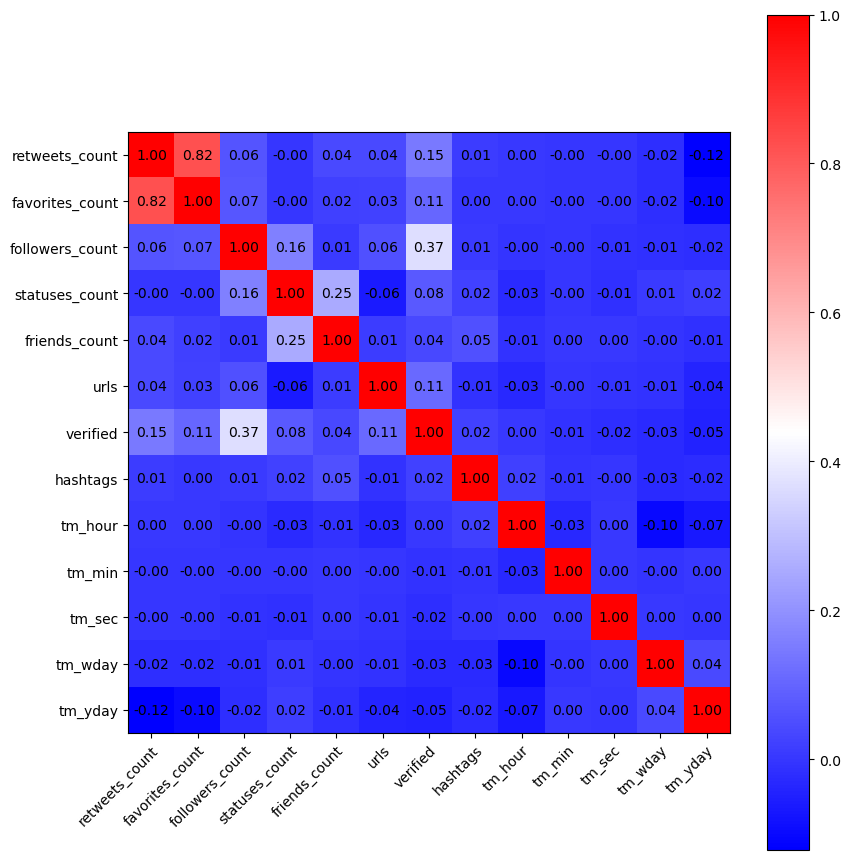

In [63]:
input_with_gts = pd.concat([train_df['retweets_count'], train_df_input], axis=1)

num_fts = input_with_gts.shape[1]
corr = np.corrcoef(input_with_gts.values.T)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(corr, cmap='bwr')
ax.set_xticks(np.arange(num_fts), labels=input_with_gts.columns)
ax.set_yticks(np.arange(num_fts), labels=input_with_gts.columns)
plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(num_fts):
    for j in range(num_fts):
        text = ax.text(j, i, '%.2f' % corr[i, j], ha="center", va="center", color="k")
fig.tight_layout()
plt.show()

# NLP

In [ ]:
nlp_model = gensim.models.Word2Vec.load('models/word2vec.model')

In [ ]:
text = train_df['text'].iloc[11].split(' ')
text_vecs = nlp_model.wv[text]
text_img = text_vecs.T @ text_vecs


print(text)
plt.imshow(text_img)
plt.show()

# Trees, Boosting

In [ ]:
full_train_X = train_df_input.values
full_train_X = (full_train_X - train_df_input.values.mean(0)) / train_df_input.values.std(0)

full_train_y = train_df['retweets_count'].values

full_test_X = (test_df_input.values - train_df_input.values.mean(0)) / train_df_input.values.std(0)

use_text = False

if use_text:
    train_text = train_df['text']
    test_text = test_df['text']

    new_train_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))
    new_test_X = np.zeros((full_train_X.shape[0], full_train_X.shape[1] + nlp_model.vector_size))

    for i in range(len(full_train_X)):
        text_vec = nlp_model.wv[train_text.iloc[i].split(' ')].mean(0)
        new_train_X[i] = np.concatenate([full_train_X[i], text_vec])

    for i in range(len(full_test_X)):
        encoded_words = [word for word in test_text.iloc[i].split(' ') if word in nlp_model.wv]
        if encoded_words:
            text_vec = nlp_model.wv[encoded_words].mean(0)
            new_test_X[i] = np.concatenate([full_test_X[i], text_vec])
        else:
            new_test_X[i] = np.concatenate([full_test_X[i], np.zeros((nlp_model.vector_size,))])

    full_train_X = new_train_X
    full_test_X = new_test_X

In [ ]:
perform_cv = False

if perform_cv:
    scores_xgboost = sklearn.model_selection.cross_validate(xgboost.XGBRegressor(verbosity=0,
                                                                                 max_depth=10),
                                                            full_train_X,
                                                            full_train_y,
                                                            cv=5,
                                                            scoring='neg_mean_absolute_error',
                                                            verbose=2)

    print(- scores_xgboost['test_score'].mean())

# Make submission

In [ ]:
make_submission = False

if make_submission:
    test_ids = test_df[['TweetID']]
    model = xgboost.XGBRegressor(verbosity=2)
    model.fit(full_train_X, full_train_y)

    test_predictions = model.predict(full_test_X)

    submission_df = pd.DataFrame(data={'retweets_count': test_predictions})
    submission_df = pd.concat([test_ids, submission_df], axis=1)
    submission_df.to_csv('data/submission.csv', index=False)